
# Clustering customers by performance (Recency Frequency Monetary + Refund)

Objective: Find high-value customer groups to prioritize marketing/sales, can pre-filter by region or parent segment


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

DATA_PATH = Path("../../[DATASET C] Retail Supply Chain Sales Analysis/[C] Retail-Supply-Chain-Sales-Analysis.xlsx")


### Filter params and Hyperparams (K)
- `region_filter`: List of areas to filter (`None` for all)
- `segment_filter`: List of parent segments to filter (`None` for all)
- `best_k`: The number of clusters after elbow/silhouette


In [2]:
region_filter = None      # Ex: ['West', 'East']
segment_filter = None     # Ex: ['Corporate', 'Consumer']
best_k = 5                # Configure after viewing graph in EDA

In [3]:
# Read & Apply filter (if exists)
df_orders = pd.read_excel(DATA_PATH, sheet_name="Retails Order Full Dataset")

if region_filter:
    df_orders = df_orders[df_orders['Region'].isin(region_filter)]
if segment_filter:
    df_orders = df_orders[df_orders['Segment'].isin(segment_filter)]

print('Number of lines after filtering:', df_orders.shape)
df_orders.head()


Number of lines after filtering: (9994, 23)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Retail Sales People,Product ID,Category,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Cassandra Brandow,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,Not,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Cassandra Brandow,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Not,731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-12-06,2016-12-06,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Anna Andreadi,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,Not,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Cassandra Brandow,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,Not,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Cassandra Brandow,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,Not,22.3680,2,0.20,2.5164


### Create features for each customer (RFM + behavior)
- RFM: Recency (most recent date), Frequency (number of orders), Monetary (revenue)
- Profit margin, average order value, discount, return rate
- Return frequency by product: rate of products that have been returned

In [4]:
orders = df_orders.copy()
orders['is_return'] = orders['Returned'].str.lower().eq('yes').astype(int)
orders['Order Date'] = pd.to_datetime(orders['Order Date'])
max_date = orders['Order Date'].max()

customer_feat = (
    orders
    .groupby(['Customer ID', 'Segment'])
    .agg(
        recency=('Order Date', lambda s: (max_date - s.max()).days),
        total_sales=('Sales', 'sum'),
        total_profit=('Profit', 'sum'),
        order_lines=('Row ID', 'count'),
        distinct_orders=('Order ID', 'nunique'),
        total_qty=('Quantity', 'sum'),
        avg_discount=('Discount', 'mean'),
        return_rate=('is_return', 'mean'),
    )
)
# RFM
customer_feat['frequency'] = customer_feat['distinct_orders']
customer_feat['monetary'] = customer_feat['total_sales']

# Profit / Unit value profile
customer_feat['profit_margin'] = customer_feat['total_profit'] / customer_feat['total_sales']
customer_feat['avg_order_value'] = customer_feat['total_sales'] / customer_feat['distinct_orders']

# Percentage of products returned
product_return = (
    orders.groupby(['Customer ID', 'Product ID'])['is_return'].max().groupby('Customer ID').agg(['sum','count'])
)
customer_feat['product_return_rate'] = product_return['sum'] / product_return['count']

customer_feat = customer_feat.replace([np.inf, -np.inf], 0).fillna(0)
customer_feat.head()


,,recency,total_sales,total_profit,order_lines,distinct_orders,total_qty,avg_discount,return_rate,frequency,monetary,profit_margin,avg_order_value,product_return_rate
Customer ID,Segment,,,,,,,,,,,,,
AA-10315,Consumer,184,5563.560,-362.8825,11,5,30,0.090909,0.000000,5,5563.560,-0.065225,1112.712000,0.0
AA-10375,Consumer,48,1056.390,277.3824,15,9,41,0.080000,0.000000,9,1056.390,0.262576,117.376667,0.0
AA-10480,Consumer,259,1790.512,435.8274,12,4,36,0.016667,0.000000,4,1790.512,0.243409,447.628000,0.0
AA-10645,Consumer,233,5086.935,857.8033,18,6,64,0.063889,0.055556,6,5086.935,0.168629,847.822500,0.0
AB-10015,Consumer,445,886.156,129.3465,6,3,13,0.066667,0.000000,3,886.156,0.145964,295.385333,0.0


### Normalize and find the right number of clusters (elbow + silhouette)
We standardize features, sweep k=2..7, and read both curves to pick k=5:
- Elbow: inertia keeps dropping but the slope bends after k≈5; beyond that the gain per extra cluster shrinks.
- Silhouette: the trivial 2-cluster case scores highest (expected), but among k≥3 the best separation/compactness is at k=5; scores fall noticeably at k=6 and only recover slightly at k=7.
- Business usefulness: 5 segments are granular enough to differentiate behaviors without over-splitting into many small groups.
=> Choose k=5 as the balance between fit improvement (inertia), cluster quality (silhouette), and interpretability.


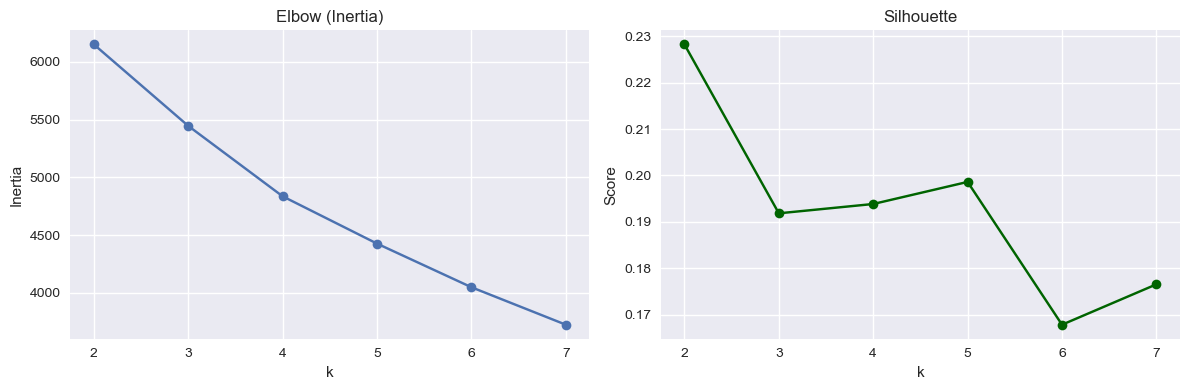

In [5]:
feature_cols = [
    'recency', 'frequency', 'monetary',
    'total_profit', 'profit_margin', 'avg_order_value',
    'order_lines', 'total_qty', 'avg_discount',
    'return_rate', 'product_return_rate'
]
X = customer_feat[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ks = range(2, 8)
inertias, silhouettes = [], []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(list(ks), inertias, marker='o')
ax[0].set_title('Elbow (Inertia)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')
ax[1].plot(list(ks), silhouettes, marker='o', color='darkgreen')
ax[1].set_title('Silhouette')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Score')
plt.tight_layout()
plt.show()


Based on the provided graphs, the best number of clusters ($k$) to select is **5**.

1.  **Silhouette Score (Right Graph):** This is the primary indicator here. While $k=2$ has the highest global score, this is often too simplistic for customer segmentation. Looking at the subsequent values, there is a distinct **local peak at $k=5$**. The score rises from $k=3$ to $k=5$, and then drops sharply at $k=6$. This indicates that 5 clusters offer a configuration with better separation and cohesion than 3, 4, or 6 clusters.

2.  **Elbow Method (Left Graph):** In the inertia graph, we look for the point where the curve begins to flatten out (the "elbow"), meaning adding more clusters yields diminishing returns. While the curve is smooth, the rate of decrease starts to stabilize after $k=5$, making the line from $k=5$ to $k=7$ flatter than the initial drops. This supports the choice of 5 derived from the Silhouette score.

Therefore, setting **`best_k = 5`** would be the optimal choice for this analysis.

### Training the KMeans model
Adjust `best_k` after looking at the two graphs above (default = 5).


In [6]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
customer_feat['cluster'] = kmeans.fit_predict(X_scaled)
customer_feat.head(10)

,,recency,total_sales,total_profit,order_lines,distinct_orders,total_qty,avg_discount,return_rate,frequency,monetary,profit_margin,avg_order_value,product_return_rate,cluster
Customer ID,Segment,,,,,,,,,,,,,,
AA-10315,Consumer,184,5563.560,-362.8825,11,5,30,0.090909,0.000000,5,5563.560,-0.065225,1112.712000,0.0,2
AA-10375,Consumer,48,1056.390,277.3824,15,9,41,0.080000,0.000000,9,1056.390,0.262576,117.376667,0.0,2
AA-10480,Consumer,259,1790.512,435.8274,12,4,36,0.016667,0.000000,4,1790.512,0.243409,447.628000,0.0,2
AA-10645,Consumer,233,5086.935,857.8033,18,6,64,0.063889,0.055556,6,5086.935,0.168629,847.822500,0.0,0
AB-10015,Consumer,445,886.156,129.3465,6,3,13,0.066667,0.000000,3,886.156,0.145964,295.385333,0.0,2
AB-10060,Home Office,105,7755.620,2054.5885,18,8,56,0.044444,0.000000,8,7755.620,0.264916,969.452500,0.0,4
AB-10105,Consumer,41,14473.571,5444.8055,20,10,73,0.240000,0.200000,10,14473.571,0.376190,1447.357100,0.0,4
AB-10150,Consumer,41,966.710,313.6597,12,5,37,0.133333,0.000000,5,966.710,0.324461,193.342000,0.0,2
AB-10165,Consumer,106,1113.838,220.8130,14,8,48,0.135714,0.000000,8,1113.838,0.198245,139.229750,0.0,2


### Clustering Result Analysis
- Cluster Size, Revenue/Profit Contribution
- Feature Profile (Median) to Reduce Outliers
- Original Segment Distribution in Each Cluster

In [7]:
cluster_size = customer_feat.groupby('cluster').size().rename('customers')
cluster_revenue = customer_feat.groupby('cluster')[['total_sales', 'total_profit']].sum()
cluster_profile = customer_feat.groupby('cluster')[feature_cols].median()
segment_mix = (
    customer_feat.reset_index()
    .pivot_table(index='cluster', columns='Segment', values='Customer ID', aggfunc='count', fill_value=0)
)

In [8]:
print('Scale & contribution:', pd.concat([cluster_size, cluster_revenue], axis=1))

Scale & contribution:          customers  total_sales  total_profit
cluster                                      
0              248  968293.1115    95458.6454
1               75  140140.4123    17264.7220
2              303  537554.2780    99434.1526
3              120  186344.2426   -32924.8693
4               47  464868.8159   107164.3710


In [9]:
print('Cluster profile (median features): ', cluster_profile)

Cluster profile (median features):           recency  frequency   monetary  total_profit  profit_margin  \
cluster                                                               
0           61.5        9.0  3438.8510      339.5754       0.113570   
1           91.0        5.0  1643.2550      189.0258       0.141562   
2           99.0        5.0  1507.0180      229.0099       0.191758   
3          298.5        4.0  1265.0840      -60.2104      -0.078103   
4           52.0        7.0  8828.0305     1933.7831       0.248039   

         avg_order_value  order_lines  total_qty  avg_discount  return_rate  \
cluster                                                                       
0             411.036375         18.0       69.0      0.164853     0.000000   
1             328.505750         10.0       36.0      0.146667     0.357143   
2             289.734333         10.0       35.0      0.112000     0.000000   
3             343.626500          7.0       29.5      0.247222     0.00

In [10]:
print('Distribution of the original Segment in each cluster:', segment_mix)

Distribution of the original Segment in each cluster: Segment  Consumer  Corporate  Home Office
cluster                                  
0             130         79           39
1              39         24           12
2             156         80           67
3              65         37           18
4              19         16           12


### Visualize 2D by PCA
Helps visualize the separation of clusters on the normalized feature space.

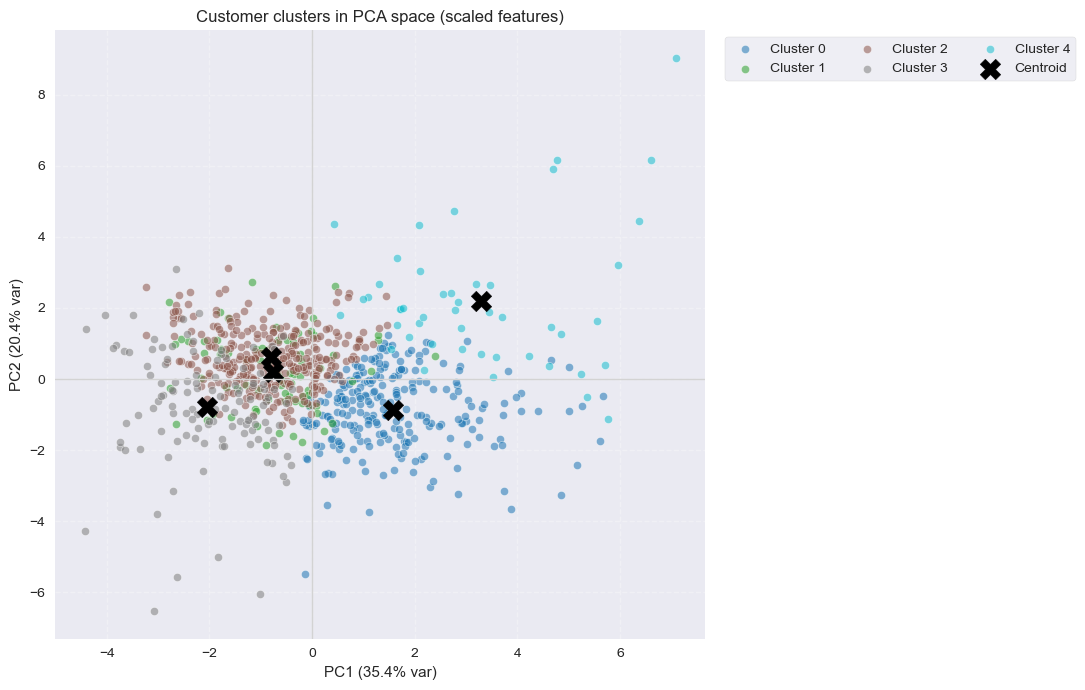

In [11]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)
expl_var = pca.explained_variance_ratio_ * 100

# Light jitter + smaller points + edge outlines to reduce overlap
rng = np.random.default_rng(42)
coords_j = coords + rng.normal(scale=0.05, size=coords.shape)

fig, ax = plt.subplots(figsize=(11, 7))
palette = plt.cm.tab10(np.linspace(0, 1, kmeans.n_clusters))
for cluster_id in sorted(customer_feat['cluster'].unique()):
    mask = customer_feat['cluster'] == cluster_id
    ax.scatter(
        coords_j[mask, 0], coords_j[mask, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.55, s=35, linewidth=0.5, edgecolor='white',
        color=palette[cluster_id]
    )
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=220, marker='X', label='Centroid')
ax.set_xlabel(f'PC1 ({expl_var[0]:.1f}% var)')
ax.set_ylabel(f'PC2 ({expl_var[1]:.1f}% var)')
ax.set_title('Customer clusters in PCA space (scaled features)')
ax.axhline(0, color='lightgray', linewidth=1)
ax.axvline(0, color='lightgray', linewidth=1)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(frameon=True, ncol=3, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Insights

- Clusters with high `monetary/total_profit`, high `profit_margin`: focus on Upsell/Cross-sell, prioritize delivery SLA.

- Clusters with high revenue but low `profit_margin` or high `avg_discount`: optimize price/promotion, consider reducing discounts.

- Clusters with high `return_rate`/`product_return_rate`: review product quality/logistics, return policy.

### Cluster 4: Champions (47 customers)

- Smallest but most valuable group. Median revenue, total profit, and profit margin are highest. They purchase frequently and recently (low recency).

-> Suggested: This group needs special care. Focus on loyalty programs, exclusive offers, new/premium product introductions (Upsell/Cross-sell), and ensuring top-notch service quality.

### Cluster 0: Loyal Customers (248 customers)

- Large group, high revenue but not very good profit margin. They purchase frequently (high frequency) but also high avg_discount.

-> Suggested: Retain them with reward programs based on purchase frequency instead of deep discounts. -> Can suggest combo packages or bulk purchases to increase the order value while maintaining the profit margin.

### Cluster 2: Core/Average Customers (303 customers)

- Largest group, average metrics. They are the company's stable revenue base.
  
-> Recommended: Nurture with personalized marketing campaigns based on purchase history to encourage them to buy more frequently and gradually move to the "Loyal Customers" group.

### Cluster 1: High-Return-Rate Customers (75 customers)

- Small group, low revenue and profit. The highlight is the very high median return_rate (35.7%).
  
-> Recommended: Need to analyze more deeply the reasons for returns of this group. Do they often buy a specific type of product? Are there any shipping issues? Temporarily do not invest much marketing costs in this group until the cause is found.

### Cluster 3: At-Risk/Lapsed Customers (120 customers)

- Haven't purchased in a long time (very high recency), highest avg_discount and negative median profit_margin.
  
-> Suggested: This group is losing money. Consider carefully before investing. -> Can try a "win-back" campaign with attractive but controlled incentives to bring them back. If it doesn't work, reduce the priority to avoid wasting resources.